# N2V Entrenamiento de los modelos

In [1]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import os


In [2]:
%load_ext tensorboard

In [25]:
# Función para calcular PSNR
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

# Función para calcular SSIM
def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

# Training Data Preparation

Para realizar el entrenamiento usamos el método <code>N2V_DataGenerator</code> para extraer datos de entrenamiento <code>X</code> y validación  <code>X_val</code> parches.

In [2]:
datagen = N2V_DataGenerator()

In [3]:
datagen.load_imgs_from_directory?

Signature: datagen.load_imgs_from_directory(directory, filter='*.tif', dims='YX')
Docstring:
Helper to read all files which match 'filter' from a directory. The images are not required to have same size,
but have to be of same dimensionality.

Parameters
----------
directory : String
            Directory from which the data is loaded.
filter    : String, optional(default='*.tif')
            Filter to match the file names.
dims      : String, optional(default='YX')
            Dimensions of the images to read. Known dimensions are: 'TZYXC'

Returns
-------
images : list(array(float))
         A list of the read tif-files. The images have dimensionality 'SZYXC' or 'SYXC'
File:      c:\users\javi\anaconda3\envs\n2v\lib\site-packages\n2v\internals\n2v_datagenerator.py
Type:      method

### Cargamos las imágenes extraidas

In [4]:
imgs = datagen.load_imgs_from_directory(directory = "Datos/", filter='*.png', dims="YXC")
# visualimzamos las dimensiones de las imágenes
print(imgs[0].shape)

(1, 573, 846, 4)


### Limpiamos el 4 canal de las imágenes

In [7]:
# Itera sobre cada imagen en la lista
for i,imagen in enumerate(imgs):
    # Elimina el canal de transparencia) de la imagen actual
    imgs[i] = imagen[:, :, :, :3]

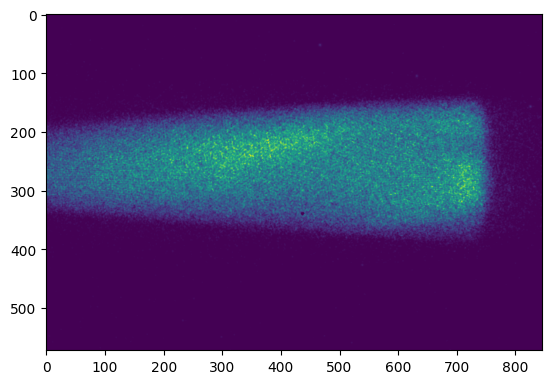

In [9]:
#Visualizamos un ejemplo de las imagenes
plt.imshow(imgs[0][0], cmap='magma')
plt.show()

# Preparamos parches y datos de entrenamiento y validación

In [17]:
# Visualizamos el método que genera los parches
datagen.generate_patches_from_list?

Signature:
datagen.generate_patches_from_list(
    data,
    num_patches_per_img=None,
    shape=(256, 256),
    augment=True,
    shuffle=False,
)
Docstring:
Extracts patches from 'list_data', which is a list of images, and returns them in a 'numpy-array'. The images
can have different dimensionality.

Parameters
----------
data                : list(array(float))
                      List of images with dimensions 'SZYXC' or 'SYXC'
num_patches_per_img : int, optional(default=None)
                      Number of patches to extract per image. If 'None', as many patches as fit i nto the
                      dimensions are extracted.
shape               : tuple(int), optional(default=(256, 256))
                      Shape of the extracted patches.
augment             : bool, optional(default=True)
                      Rotate the patches in XY-Plane and flip them along X-Axis. This only works if the patches are square in XY.
shuffle             : bool, optional(default=False)
       

In [12]:
#Calculamos la contidad de datos que vamos a usar en el entrenamiento
num_filas_entrenamiento = int(imgs[0].shape[1] * 0.8)
print(num_filas_entrenamiento)

458


In [13]:

# Se calcula que el 80% de los parches seran para entrenamiento y el resto será para validacion 
num_filas_entrenamiento = int(imgs[0].shape[1] * 0.8)


imgs_train = [imgs[0][:,:num_filas_entrenamiento]]
X = datagen.generate_patches_from_list(imgs,shape=(64,64))
imgs_vali = [imgs[0][:,num_filas_entrenamiento:]]
X_val = datagen.generate_patches_from_list(imgs,shape=(64,64))


Generated patches: (832, 64, 64, 3)
Generated patches: (832, 64, 64, 3)
Generated patches: (832, 64, 64, 3)
Generated patches: (832, 64, 64, 3)
Generated patches: (832, 64, 64, 3)
Generated patches: (832, 64, 64, 3)
Generated patches: (832, 64, 64, 3)
Generated patches: (832, 64, 64, 3)
Generated patches: (832, 64, 64, 3)
Generated patches: (832, 64, 64, 3)
Generated patches: (832, 64, 64, 3)
Generated patches: (832, 64, 64, 3)
Generated patches: (832, 64, 64, 3)
Generated patches: (832, 64, 64, 3)
Generated patches: (832, 64, 64, 3)
Generated patches: (832, 64, 64, 3)
Generated patches: (832, 64, 64, 3)
Generated patches: (832, 64, 64, 3)
Generated patches: (832, 64, 64, 3)
Generated patches: (832, 64, 64, 3)
Generated patches: (832, 64, 64, 3)
Generated patches: (832, 64, 64, 3)
Generated patches: (832, 64, 64, 3)
Generated patches: (832, 64, 64, 3)
Generated patches: (832, 64, 64, 3)
Generated patches: (832, 64, 64, 3)
Generated patches: (832, 64, 64, 3)
Generated patches: (832, 64,

In [15]:
#Visualizamo cantidad de parches
print(len(X))

64128


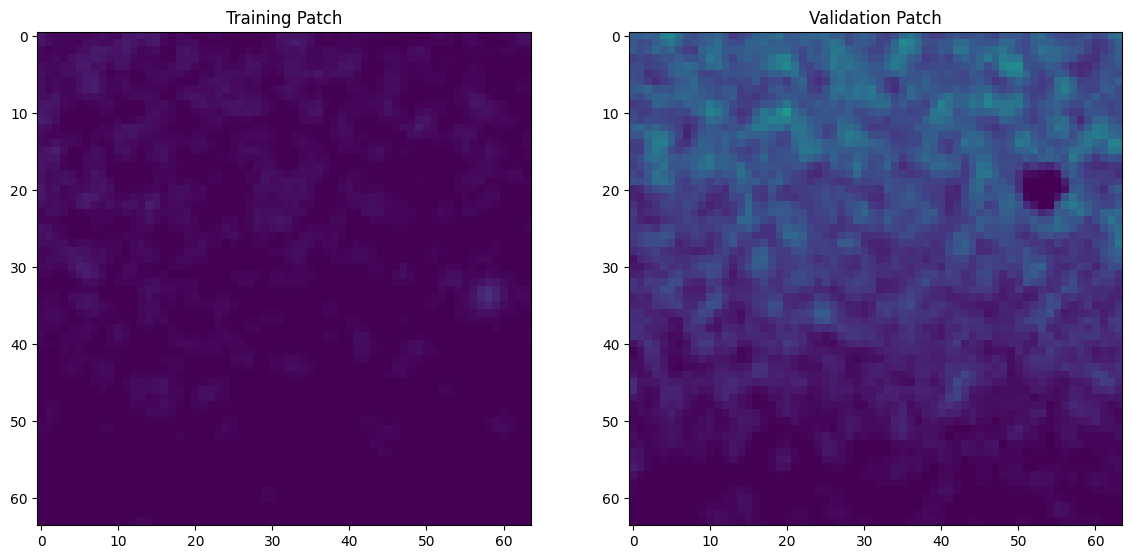

In [19]:
# Visualicemos los parches generados durante el preprocesado
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0], cmap='magma')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0], cmap='magma')
plt.title('Validation Patch');

# Configuración de hiper parámetros del modelo

In [21]:
#Usamos método para configurar los modelos
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=int(X.shape[0]/128), train_epochs=20, train_loss='mse', batch_norm=True, 
                   train_batch_size=128, n2v_perc_pix=0.20, n2v_patch_shape=(64, 64), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5, structN2Vmask = [[0,1,1,1,1,1,1,1,1,1,0]])

#Visualizamos la configuración del modelo
vars(config)

{'means': ['0.22679064', '0.2484119', '0.45646334'],
 'stds': ['0.05386791', '0.22314036', '0.10007944'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 3,
 'unet_residual': False,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 3),
 'train_loss': 'mse',
 'train_epochs': 20,
 'train_steps_per_epoch': 501,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.2,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'single_net_per_channel': True,
 'blurpool': False,
 'skip_skipone': False,
 'structN2Vmask': [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]],
 'probabilistic': False}

In [24]:
# creamos nombre del modelo
model_name = 'n2v_ALBA_Prueba_Tensor9'
#directorio donde guardar el modelo
basedir = 'models'
# creamos el modelo
model = N2V(config, model_name, basedir=basedir)

# Training


In [ ]:
# We are ready to start training now.
history = model.train(X, X_val)

StructN2V Mask is:  [[0 1 1 1 1 1 1 1 1 1 0]]
8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 64128/64128 [00:32<00:00, 1988.09it/s]


Epoch 1/20
501/501 [==============================] - 2819s 6s/step - loss: 0.1297 - n2v_mse: 0.1297 - n2v_abs: 0.2113 - val_loss: 0.3524 - val_n2v_mse: 0.3524 - val_n2v_abs: 0.3973 - lr: 4.0000e-04
Epoch 2/20
501/501 [==============================] - 2794s 6s/step - loss: 0.0693 - n2v_mse: 0.0693 - n2v_abs: 0.1460 - val_loss: 0.2639 - val_n2v_mse: 0.2639 - val_n2v_abs: 0.3173 - lr: 4.0000e-04
Epoch 3/20
501/501 [==============================] - 2786s 6s/step - loss: 0.0599 - n2v_mse: 0.0599 - n2v_abs: 0.1313 - val_loss: 0.2761 - val_n2v_mse: 0.2761 - val_n2v_abs: 0.3210 - lr: 4.0000e-04
Epoch 4/20
501/501 [==============================] - 2791s 6s/step - loss: 0.0553 - n2v_mse: 0.0553 - n2v_abs: 0.1237 - val_loss: 0.2848 - val_n2v_mse: 0.2848 - val_n2v_abs: 0.3138 - lr: 4.0000e-04
Epoch 5/20
501/501 [==============================] - 2785s 6s/step - loss: 0.0531 - n2v_mse: 0.0531 - n2v_abs: 0.1197 - val_loss: 0.3078 - val_n2v_mse: 0.3078 - val_n2v_abs: 0.3423 - lr: 4.0000e-04
Epoch

In [16]:
%tensorboard --logdir logs9/fit

# Visualizamos como ha ido el entrenamiento del modelo

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


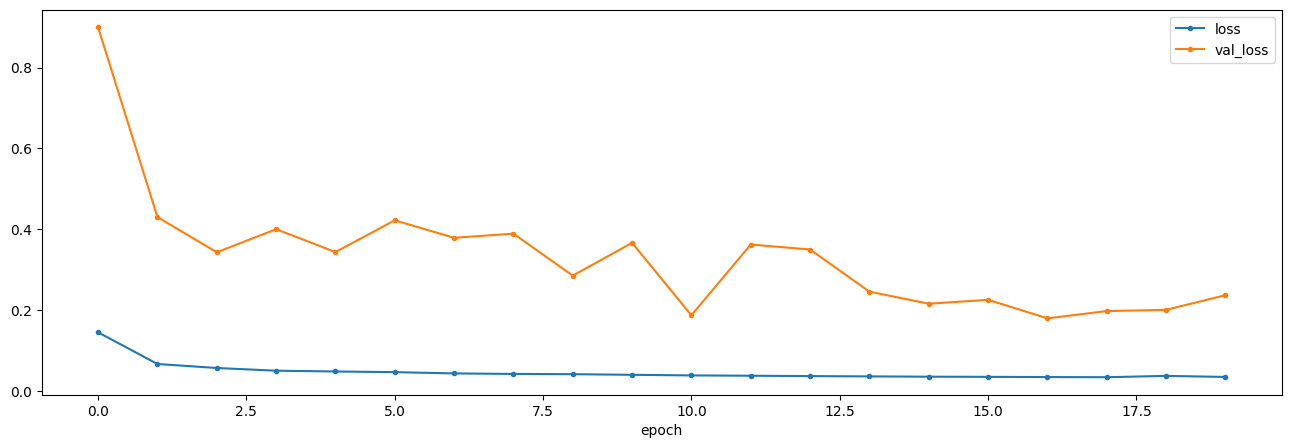

In [17]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

## Exportamos el modelo como indican los ejemplos


In [ ]:
model.export_TF(name='Struct Noise2Void - n2v_ALBA_Prueba_Tensor9', 
                description='This is the Struct Noise2Void trained on the ALBA data in python.',
                authors="Javier de vicente",
                test_img=X_val[0], axes='YXC',
                patch_shape=(64,64))